In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaModel, AdamW
from transformers import RobertaTokenizer
import torch.optim as optim
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import numpy as np
import os

2023-10-11 07:03:26.605945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class BertAtt(nn.Module):
    def __init__(self, d_e, h):
        super(BertAtt, self).__init__()
        self.num_heads = h
        self.d_e = d_e
        self.head_dim = d_e // h
        
        self.q = nn.Linear(d_e, d_e)
        self.k = nn.Linear(d_e, d_e)
        self.v = nn.Linear(d_e, d_e)
        
        self.o = nn.Linear(d_e, d_e)
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)
        
        Q = Q.view(Q.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(K.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(V.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        
        attention_scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / (self.d_e**0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_probs, V)
        
        context = context.permute(0, 2, 1, 3).contiguous()
        context = context.view(context.size(0), -1, self.num_heads*self.head_dim)
        context = self.dropout(context)
        context = self.o(context)
        
        return self.layer_norm(x + context)

class HBN(nn.Module):
    def __init__(self, d_e, h, m, n, y, dropout_prob=0.01, max_sentences=114):
        super(HBN, self).__init__()
        
        # Token-level Roberta encoder
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        
        # Freeze Roberta weights
        for param in self.roberta.parameters():
            param.requires_grad = False
        
        # Sentence-level BERT Encoder
        self.bertatt = BertAtt(d_e, h)
        
        self.ff = nn.Sequential(
            nn.Linear(d_e, n*d_e),
            nn.ReLU(),
            nn.Linear(n*d_e, d_e)
        )
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.multiple_bert_layers = nn.ModuleList([BertAtt(d_e, h) for _ in range(m)])
        
        self.transformation = nn.Linear(d_e, d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        # Prediction Layer
        self.predict = nn.Linear(d_e, y)
        
    def forward(self, input_ids, attention_mask):
#         print(input_ids.shape)
        # Token-level Roberta encoding
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]  # [batch_size, seq_length, hidden_size]
        
        # Average pooling to get sentence embeddings
        D = torch.mean(roberta_outputs, dim=1)  # [batch_size, hidden_size]
        
        out = self.bertatt(D)
        out = self.layer_norm(out + F.relu(self.ff(out)))
        
        Z = out
        for layer in self.multiple_bert_layers:
            Z = layer(Z)
        
        S = torch.tanh(torch.mean(Z, dim=1).mm(self.transformation.weight))
        S = self.dropout(S)
        scores = S.mm(self.predict.weight.t())
        
        return scores


In [3]:
# Parameters
d_e = 768  # Assuming you are using 'roberta-base'
h = 1     # Number of attention heads
m = 4      # Number of identical BERT layers
n = 4      # Scaling factor for feed-forward network
y = 2      # Number of classes, set this to your actual number
dropout_prob = 0.01 #dropout probability
num_train_samples = 100
num_epochs = 50
max_length = 128

In [4]:
import os
import pandas as pd
from nltk.tokenize import sent_tokenize

folder1_path = 'sample-text/sample-text/politics/'
folder2_path = 'sample-text/sample-text/business/'

# Fetch file names from both folders
folder1_files = [f for f in os.listdir(folder1_path) if f.endswith('.txt')]
folder2_files = [f for f in os.listdir(folder2_path) if f.endswith('.txt')]

combined_data = []
num_sent=[]

# Read and label files from folder1 and count sentences
for file in folder1_files:
    with open(os.path.join(folder1_path, file), 'r') as f:
        content = f.read()
        num_sentences = len(sent_tokenize(content))
        combined_data.append((content, 0))
        num_sent.append(num_sentences)

# Read and label files from folder2 and count sentences
for file in folder2_files:
    with open(os.path.join(folder2_path, file), 'r') as f:
        content = f.read()
        num_sentences = len(sent_tokenize(content))
        combined_data.append((content, 1))
        num_sent.append(num_sentences)

# Convert combined_data to DataFrame
df = pd.DataFrame(combined_data, columns=['content', 'label'])

# Shuffle the DataFrame
data = df.sample(frac=1).reset_index(drop=True)

# Display the shuffled DataFrame
print(data)

# Find out the maximum number of sentences across all files
max_sentences = max(num_sent)
print(f"\nMaximum number of sentences across all files: {max_sentences}")


                                               content  label
0    Opposition grows to house arrests\n\nThe Conse...      0
1    Commons hunt protest charges\n\nEight proteste...      0
2    Kilroy-Silk quits 'shameful' UKIP\n\nEx-chat s...      0
3    Petrol duties frozen, Brown says\n\nChancellor...      0
4    EU aiming to fuel development aid\n\nEuropean ...      1
..                                                 ...    ...
593  China keeps tight rein on credit\n\nChina's ef...      1
594  Australia rates at four year high\n\nAustralia...      1
595  Hague 'given up' his PM ambition\n\nFormer Con...      0
596  Blair congratulates Bush on win\n\nTony Blair ...      0
597  Howard rebuts asylum criticisms\n\nTory leader...      0

[598 rows x 2 columns]

Maximum number of sentences across all files: 248


In [5]:
# len(test_indices),len(train_indices),len(val_indices)

In [6]:
# len(reviews_sentences)

In [7]:
# 2. Split data into train, validation, and test samples
num_train_samples = num_train_samples
num_val_samples = int(0.2 * num_train_samples)
train_data = data.iloc[:num_train_samples]
val_data = data.iloc[num_train_samples:num_train_samples+num_val_samples]
test_data = data.iloc[num_train_samples+num_val_samples:]

# 3. Preprocess and Flatten
def preprocess_and_flatten(dataframe):
    reviews = dataframe['content'].tolist()
    labels = dataframe['label'].tolist()
    reviews = [review.lower() for review in reviews]
    reviews_sentences = [sent_tokenize(review) for review in reviews]
    flattened_reviews = [sentence for review in reviews_sentences for sentence in review]
    flattened_labels = [label for review, label in zip(reviews_sentences, labels) for sentence in review]
    return flattened_reviews, flattened_labels

train_reviews, train_labels = preprocess_and_flatten(train_data)
val_reviews, val_labels = preprocess_and_flatten(val_data)
test_reviews, test_labels = preprocess_and_flatten(test_data)

# 4. Tokenization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_tokens = tokenizer(train_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
val_tokens = tokenizer(val_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
test_tokens = tokenizer(test_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)

# 5. Create DataLoader
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(train_labels))
val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], torch.tensor(val_labels))
test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=val_batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

# Uncomment to test: iterating over the DataLoader
for batch in train_loader:
    input_ids, attention_mask, labels = batch
    print(input_ids.shape, attention_mask.shape, labels.shape)
len(train_loader.dataset),len(val_loader.dataset),len(test_loader.dataset)

torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4,

(1929, 351, 8488)

In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = HBN(d_e, h, m, n, y, dropout_prob).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def train(model, dataloader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            
            # For AUC
            # Assuming binary classification; you need to get the probabilities for the positive class
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    auc = roc_auc_score(all_labels, all_preds)
    return total_loss / len(dataloader), accuracy, auc



In [10]:
# Actual Training Loop
train_loss_epoch = []
test_loss_epoch = []
auc = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    print(f"Train Loss: {train_loss:.4f}")
    val_loss, val_accuracy, val_auc = evaluate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")
    train_loss_epoch.append(train_loss)
    test_loss_epoch.append(val_loss)
    auc.append(val_auc)

Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████████| 483/483 [01:20<00:00,  5.99it/s]


Train Loss: 0.4365


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00,  9.95it/s]


Val Loss: 0.2670, Val Accuracy: 0.9003, Val AUC: 0.9716


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████| 483/483 [01:22<00:00,  5.85it/s]


Train Loss: 0.2683


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.36it/s]


Val Loss: 0.2176, Val Accuracy: 0.9288, Val AUC: 0.9763


Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████| 483/483 [01:45<00:00,  4.58it/s]


Train Loss: 0.2288


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:15<00:00,  5.70it/s]


Val Loss: 0.1799, Val Accuracy: 0.9345, Val AUC: 0.9795


Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████| 483/483 [02:23<00:00,  3.37it/s]


Train Loss: 0.2242


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:16<00:00,  5.18it/s]


Val Loss: 0.2098, Val Accuracy: 0.9231, Val AUC: 0.9761


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████| 483/483 [02:19<00:00,  3.45it/s]


Train Loss: 0.2032


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:14<00:00,  5.92it/s]


Val Loss: 0.2122, Val Accuracy: 0.9145, Val AUC: 0.9752


Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████| 483/483 [01:59<00:00,  4.04it/s]


Train Loss: 0.1998


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:16<00:00,  5.22it/s]


Val Loss: 0.2098, Val Accuracy: 0.9088, Val AUC: 0.9769


Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████| 483/483 [02:25<00:00,  3.32it/s]


Train Loss: 0.1726


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:15<00:00,  5.51it/s]


Val Loss: 0.1981, Val Accuracy: 0.9202, Val AUC: 0.9762


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████████| 483/483 [02:02<00:00,  3.95it/s]


Train Loss: 0.1843


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00,  9.88it/s]


Val Loss: 0.2062, Val Accuracy: 0.9231, Val AUC: 0.9750


Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████| 483/483 [01:19<00:00,  6.11it/s]


Train Loss: 0.1847


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.07it/s]


Val Loss: 0.2009, Val Accuracy: 0.9288, Val AUC: 0.9761


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:18<00:00,  6.17it/s]


Train Loss: 0.1650


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.11it/s]


Val Loss: 0.2217, Val Accuracy: 0.9117, Val AUC: 0.9724


Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:18<00:00,  6.14it/s]


Train Loss: 0.1647


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00,  9.94it/s]


Val Loss: 0.2045, Val Accuracy: 0.9174, Val AUC: 0.9752


Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [02:05<00:00,  3.84it/s]


Train Loss: 0.1750


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:16<00:00,  5.45it/s]


Val Loss: 0.2086, Val Accuracy: 0.9117, Val AUC: 0.9767


Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [02:21<00:00,  3.41it/s]


Train Loss: 0.1527


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:15<00:00,  5.57it/s]


Val Loss: 0.2299, Val Accuracy: 0.8946, Val AUC: 0.9769


Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:31<00:00,  5.30it/s]


Train Loss: 0.1610


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.71it/s]


Val Loss: 0.2458, Val Accuracy: 0.8917, Val AUC: 0.9775


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.22it/s]


Train Loss: 0.1496


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.18it/s]


Val Loss: 0.2300, Val Accuracy: 0.9060, Val AUC: 0.9733


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.23it/s]


Train Loss: 0.1477


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.68it/s]


Val Loss: 0.2319, Val Accuracy: 0.9117, Val AUC: 0.9704


Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:18<00:00,  6.13it/s]


Train Loss: 0.1414


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.18it/s]


Val Loss: 0.2205, Val Accuracy: 0.9174, Val AUC: 0.9738


Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.20it/s]


Train Loss: 0.1309


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.10it/s]


Val Loss: 0.2497, Val Accuracy: 0.9003, Val AUC: 0.9709


Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:18<00:00,  6.17it/s]


Train Loss: 0.1409


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.18it/s]


Val Loss: 0.3932, Val Accuracy: 0.8519, Val AUC: 0.9705


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:21<00:00,  5.94it/s]


Train Loss: 0.1332


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.85it/s]


Val Loss: 0.2906, Val Accuracy: 0.8889, Val AUC: 0.9677


Epoch 21/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:18<00:00,  6.16it/s]


Train Loss: 0.1399


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.18it/s]


Val Loss: 0.2548, Val Accuracy: 0.9031, Val AUC: 0.9734


Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.25it/s]


Train Loss: 0.1419


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.17it/s]


Val Loss: 0.2142, Val Accuracy: 0.9145, Val AUC: 0.9719


Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.22it/s]


Train Loss: 0.1346


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.05it/s]


Val Loss: 0.2383, Val Accuracy: 0.9145, Val AUC: 0.9721


Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.26it/s]


Train Loss: 0.1358


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.10it/s]


Val Loss: 0.2381, Val Accuracy: 0.9174, Val AUC: 0.9707


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.26it/s]


Train Loss: 0.1340


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.09it/s]


Val Loss: 0.3352, Val Accuracy: 0.8661, Val AUC: 0.9685


Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.25it/s]


Train Loss: 0.1185


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.18it/s]


Val Loss: 0.2633, Val Accuracy: 0.8917, Val AUC: 0.9689


Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.24it/s]


Train Loss: 0.1274


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.71it/s]


Val Loss: 0.2206, Val Accuracy: 0.9145, Val AUC: 0.9707


Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.26it/s]


Train Loss: 0.1175


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.71it/s]


Val Loss: 0.2395, Val Accuracy: 0.9003, Val AUC: 0.9688


Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:18<00:00,  6.19it/s]


Train Loss: 0.1181


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00,  9.85it/s]


Val Loss: 0.4339, Val Accuracy: 0.8604, Val AUC: 0.9663


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:19<00:00,  6.07it/s]


Train Loss: 0.1236


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.17it/s]


Val Loss: 0.2842, Val Accuracy: 0.9031, Val AUC: 0.9673


Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:18<00:00,  6.12it/s]


Train Loss: 0.1145


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.55it/s]


Val Loss: 0.2539, Val Accuracy: 0.9031, Val AUC: 0.9678


Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:18<00:00,  6.19it/s]


Train Loss: 0.1144


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.67it/s]


Val Loss: 0.3114, Val Accuracy: 0.8917, Val AUC: 0.9665


Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.25it/s]


Train Loss: 0.1168


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.68it/s]


Val Loss: 0.2294, Val Accuracy: 0.9060, Val AUC: 0.9692


Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.24it/s]


Train Loss: 0.1119


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00,  9.85it/s]


Val Loss: 0.2949, Val Accuracy: 0.8917, Val AUC: 0.9690


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:18<00:00,  6.13it/s]


Train Loss: 0.1041


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.62it/s]


Val Loss: 0.2459, Val Accuracy: 0.8946, Val AUC: 0.9667


Epoch 36/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.22it/s]


Train Loss: 0.1134


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.17it/s]


Val Loss: 0.2504, Val Accuracy: 0.9088, Val AUC: 0.9676


Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.23it/s]


Train Loss: 0.1017


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.58it/s]


Val Loss: 0.2958, Val Accuracy: 0.9031, Val AUC: 0.9691


Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.23it/s]


Train Loss: 0.1020


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.14it/s]


Val Loss: 0.2689, Val Accuracy: 0.8974, Val AUC: 0.9660


Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.21it/s]


Train Loss: 0.0908


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.18it/s]


Val Loss: 0.2667, Val Accuracy: 0.9145, Val AUC: 0.9690


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.24it/s]


Train Loss: 0.0904


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.16it/s]


Val Loss: 0.2923, Val Accuracy: 0.8946, Val AUC: 0.9657


Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.25it/s]


Train Loss: 0.1127


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.71it/s]


Val Loss: 0.3504, Val Accuracy: 0.8889, Val AUC: 0.9655


Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.23it/s]


Train Loss: 0.1024


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.69it/s]


Val Loss: 0.3856, Val Accuracy: 0.8775, Val AUC: 0.9603


Epoch 43/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.24it/s]


Train Loss: 0.0958


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.70it/s]


Val Loss: 0.2768, Val Accuracy: 0.8974, Val AUC: 0.9646


Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.20it/s]


Train Loss: 0.1116


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.42it/s]


Val Loss: 0.2386, Val Accuracy: 0.9031, Val AUC: 0.9677


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:20<00:00,  5.97it/s]


Train Loss: 0.0867


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.47it/s]


Val Loss: 0.3487, Val Accuracy: 0.8974, Val AUC: 0.9626


Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:20<00:00,  5.99it/s]


Train Loss: 0.0968


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.19it/s]


Val Loss: 0.3408, Val Accuracy: 0.8803, Val AUC: 0.9596


Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.25it/s]


Train Loss: 0.0972


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.62it/s]


Val Loss: 0.3042, Val Accuracy: 0.9117, Val AUC: 0.9655


Epoch 48/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.24it/s]


Train Loss: 0.1003


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.13it/s]


Val Loss: 0.2916, Val Accuracy: 0.8946, Val AUC: 0.9615


Epoch 49/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.24it/s]


Train Loss: 0.0876


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.69it/s]


Val Loss: 0.2734, Val Accuracy: 0.9031, Val AUC: 0.9661


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.25it/s]


Train Loss: 0.0888


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.13it/s]

Val Loss: 0.3004, Val Accuracy: 0.8974, Val AUC: 0.9639


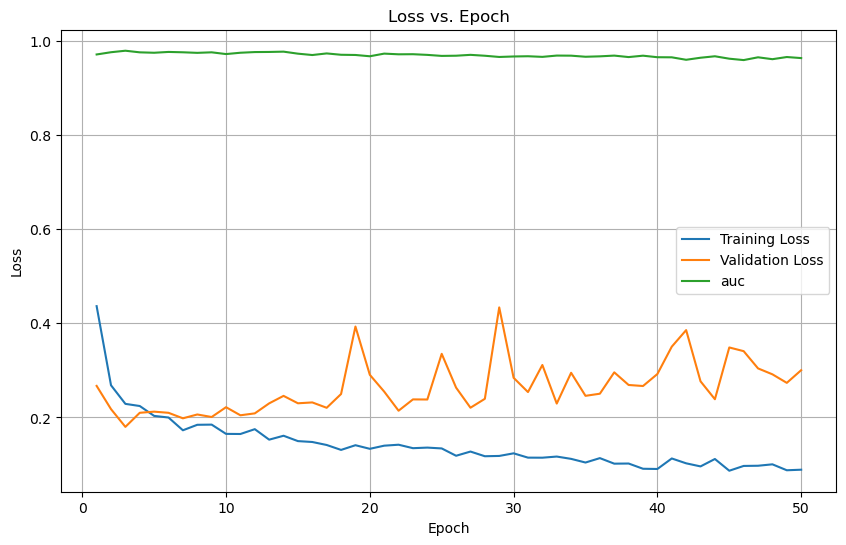

In [11]:
import matplotlib.pyplot as plt

# Plot Loss vs. Epoch
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_epoch, label='Training Loss')
plt.plot(epochs, test_loss_epoch, label='Validation Loss')
plt.plot(epochs, auc, label='auc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
val_loss, val_accuracy, val_auc = evaluate(model, test_loader, criterion, device)
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████| 2122/2122 [04:41<00:00,  7.54it/s]

Val Loss: 0.3867, Val Accuracy: 0.8829, Val AUC: 0.9473


In [13]:
len(test_loader.dataset)

8488